## Environmental Source Apportionment Toolkit (ESAT) Solution Eval


In [1]:
# Notebook imports
import os
import sys
import json
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Code Imports

In [2]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.metrics import q_loss, qr_loss

#### Synthetic Dataset

Generate a synthetic dataset where the factor profiles and contributions are pre-determined for model output analysis.

In [3]:
seed = 42

syn_factors = 6
syn_features = 40
syn_samples = 200

rng = np.random.default_rng(seed)
syn_factor_profiles = np.zeros(shape=(syn_factors, syn_features))
syn_factor_contributions = rng.random(size=(syn_samples, syn_factors)) * 10
factor_list = list(range(syn_factors))
for i in range(syn_features):
    factor_features_n = rng.integers(1, syn_factors, 1)     # Number of factors which will have a non-zero value in the profile for this feature
    factor_feature_selected = rng.choice(factor_list, size=factor_features_n, replace=False)     # The specific factors which have a non-zero value in the profile for this feature
    for j in factor_feature_selected:
        ij_value = rng.random(size=1)
        syn_factor_profiles[j, i] = ij_value

syn_factor_profiles[syn_factor_profiles == 0.0] = 1e-12

syn_data = np.matmul(syn_factor_contributions, syn_factor_profiles)
noise = syn_data * np.random.normal(loc=0.1, scale=0.05, size=syn_data.shape)
syn_data = np.add(syn_data, noise)

syn_unc_p = np.random.normal(loc=0.05, scale=0.01, size=syn_data.shape)
syn_uncertainty = syn_data * syn_unc_p
syn_uncertainty[syn_uncertainty <= 0.0] = 1e-12

C:\Users\dsmith\AppData\Local\Temp\ipykernel_38608\1408066339.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  syn_factor_profiles[j, i] = ij_value


In [4]:
syn_columns = [f"Feature {i}" for i in range(1, syn_features+1)]
syn_input_df = pd.DataFrame(syn_data, columns=syn_columns)
syn_uncertainty_df = pd.DataFrame(syn_uncertainty, columns=syn_columns)

#### Input Parameters

In [5]:
index_col = "Date"                  # the index of the input/uncertainty datasets
factors = 6                         # the number of factors
method = "ls-nmf"                   # "ls-nmf", "ws-nmf"
models = 20                         # the number of models to train
init_method = "col_means"           # default is column means "col_means", "kmeans", "cmeans"
init_norm = True                    # if init_method=kmeans or cmeans, normalize the data prior to clustering.
seed = 42                           # random seed for initialization
max_iterations = 20000              # the maximum number of iterations for fitting a model
converge_delta = 0.1                # convergence criteria for the change in loss, Q
converge_n = 10                     # convergence criteria for the number of steps where the loss changes by less than converge_delta
verbose = True                      # adds more verbosity to the algorithm workflow on execution.
optimized = True                    # use the Rust code if possible
parallel = True                     # execute the model training in parallel, multiple models at the same time

In [6]:
syn_sa = SA(V=syn_input_df.to_numpy(), U=syn_uncertainty_df.to_numpy(), factors=factors, seed=seed, optimized=optimized, parallelized=parallel, verbose=verbose)
syn_sa.H = syn_factor_profiles
syn_sa.W = syn_factor_contributions
syn_sa.WH = syn_data
syn_sa.Qrobust = qr_loss(V=syn_sa.V, U=syn_sa.U, W=syn_sa.W, H=syn_sa.H)
syn_sa.Qtrue = q_loss(V=syn_sa.V, U=syn_sa.U, W=syn_sa.W, H=syn_sa.H)

syn_factor_columns = [f"Factor {i}" for i in range(1, factors+1)]
syn_profile_df = pd.DataFrame(syn_factor_profiles.T, columns=syn_factor_columns)
syn_contribution_df = pd.DataFrame(syn_factor_contributions, columns=syn_factor_columns)

#### Load Data
Assign the processed data and uncertainty datasets to the variables V and U. These steps will be simplified/streamlined in a future version of the code.

In [7]:
data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
V, U = data_handler.get_data()

#### Input/Uncertainty Data Metrics and Visualizations

In [8]:
# Show the input data metrics, including signal to noise ratio of the data and uncertainty
data_handler.metrics

Category        S/N       Min       25th       50th       75th  \
Feature 1    Strong  20.560559  0.045430   1.897520   3.115649   4.550686   
Feature 2    Strong  20.383256  0.020560   0.289185   0.394176   0.549569   
Feature 3    Strong  19.824305  4.306792  11.610366  14.541619  17.167615   
Feature 4    Strong  19.741562  0.014404   1.423428   2.880795   4.804760   
Feature 5    Strong  20.329948  3.724806  10.902796  14.057057  17.840935   
Feature 6    Strong  19.710365  0.009062   1.141314   2.524451   3.820635   
Feature 7    Strong  19.699200  1.803476   6.929788   8.959611  11.042513   
Feature 8    Strong  19.361538  0.346322   3.010198   4.218950   5.130007   
Feature 9    Strong  19.946868  0.778708   8.671261  11.345209  14.621783   
Feature 10   Strong  19.847355  1.855644  11.297254  13.966626  17.389396   
Feature 11   Strong  19.577313  2.330375  11.477692  14.215912  17.187103   
Feature 12   Strong  19.745496  2.234777   8.079109   9.920953  12.098852   
Feature 13   Strong  19.822927  0.553888   5.537390   8.372322  10.453402   
Feature 14   Strong  20.501318  0.960779  10.356073  13.580863  17.026453   
Feature 15   Strong  19.851098  1.351152   8.980092  11.329950  13.347942   
Feature 16   Strong  19.847818  2.805670   9.405932  12.107698  14.414718   
Feature 17   Strong  19.896151  0.435805   6.884239   9.612875  11.896509   
Feature 18   Strong  19.839513  2.007986  12.738632  16.170905  19.429460   
Feature 19   Strong  19.950626  0.040814   1.974386   4.273872   6.362468   
Feature 20   Strong  19.430616  2.311272  13.247535  16.669709  20.072533   
Feature 21   Strong  20.317153  0.004363   2.767234   4.993414   6.902404   
Feature 22   Strong  20.641888  5.412026  15.183580  18.938461  22.501052   
Feature 23   Strong  19.997110  2.307420  10.151983  13.303567  15.741630   
Feature 24   Strong  20.283348  1.588204   9.071266  11.444220  13.652661   
Feature 25   Strong  19.990874  4.484136  13.066359  17.147218  22.148742   
Feature 26   Strong  20.362707  0.308448   3.599117   4.888076   6.217067   
Feature 27   Strong  19.538146  0.019051   2.693739   5.342191   8.013745   
Feature 28   Strong  20.199037  0.040554   3.232861   5.520773   7.589874   
Feature 29   Strong  19.431937  0.064158   0.682192   1.001294   1.338014   
Feature 30   Strong  19.978321  0.000891   0.498381   0.919111   1.284628   
Feature 31   Strong  20.037575  0.795430   6.952718  10.496823  12.354148   
Feature 32   Strong  20.013256  5.872374  14.507651  18.436753  22.496566   
Feature 33   Strong  20.281395  2.983533  12.418702  16.085221  19.357431   
Feature 34   Strong  22.004146  0.507039   4.874892   6.537873   7.783395   
Feature 35   Strong  19.950990  0.003647   0.172327   0.387220   0.654300   
Feature 36   Strong  19.831622  0.331704   2.659635   4.420539   6.102720   
Feature 37   Strong  19.230724  1.325061   5.312678   8.060204  10.788422   
Feature 38   Strong  20.758101  0.014591   1.350666   2.915790   4.792968   
Feature 39   Strong  20.529969  0.303983   2.554726   4.395279   6.262599   
Feature 40   Strong  20.307442  0.407422   5.542746   8.054013  10.146230   

                  Max  
Feature 1    6.189894  
Feature 2    0.794487  
Feature 3   26.050659  
Feature 4    6.432837  
Feature 5   27.428187  
Feature 6    5.428922  
Feature 7   16.284785  
Feature 8    7.368853  
Feature 9   20.517019  
Feature 10  23.852880  
Feature 11  27.112981  
Feature 12  16.377070  
Feature 13  15.639915  
Feature 14  28.399182  
Feature 15  18.453408  
Feature 16  19.873920  
Feature 17  16.448427  
Feature 18  25.717581  
Feature 19   9.083595  
Feature 20  25.500912  
Feature 21  10.358191  
Feature 22  33.885575  
Feature 23  21.729716  
Feature 24  19.673041  
Feature 25  30.333529  
Feature 26   8.985794  
Feature 27  11.511900  
Feature 28  10.267164  
Feature 29   2.016730  
Feature 30   1.806180  
Feature 31  17.907425  
Feature 32  30.958807  
Feature 33  29.780880  
Feature 34  11.064638  
Feature 35   

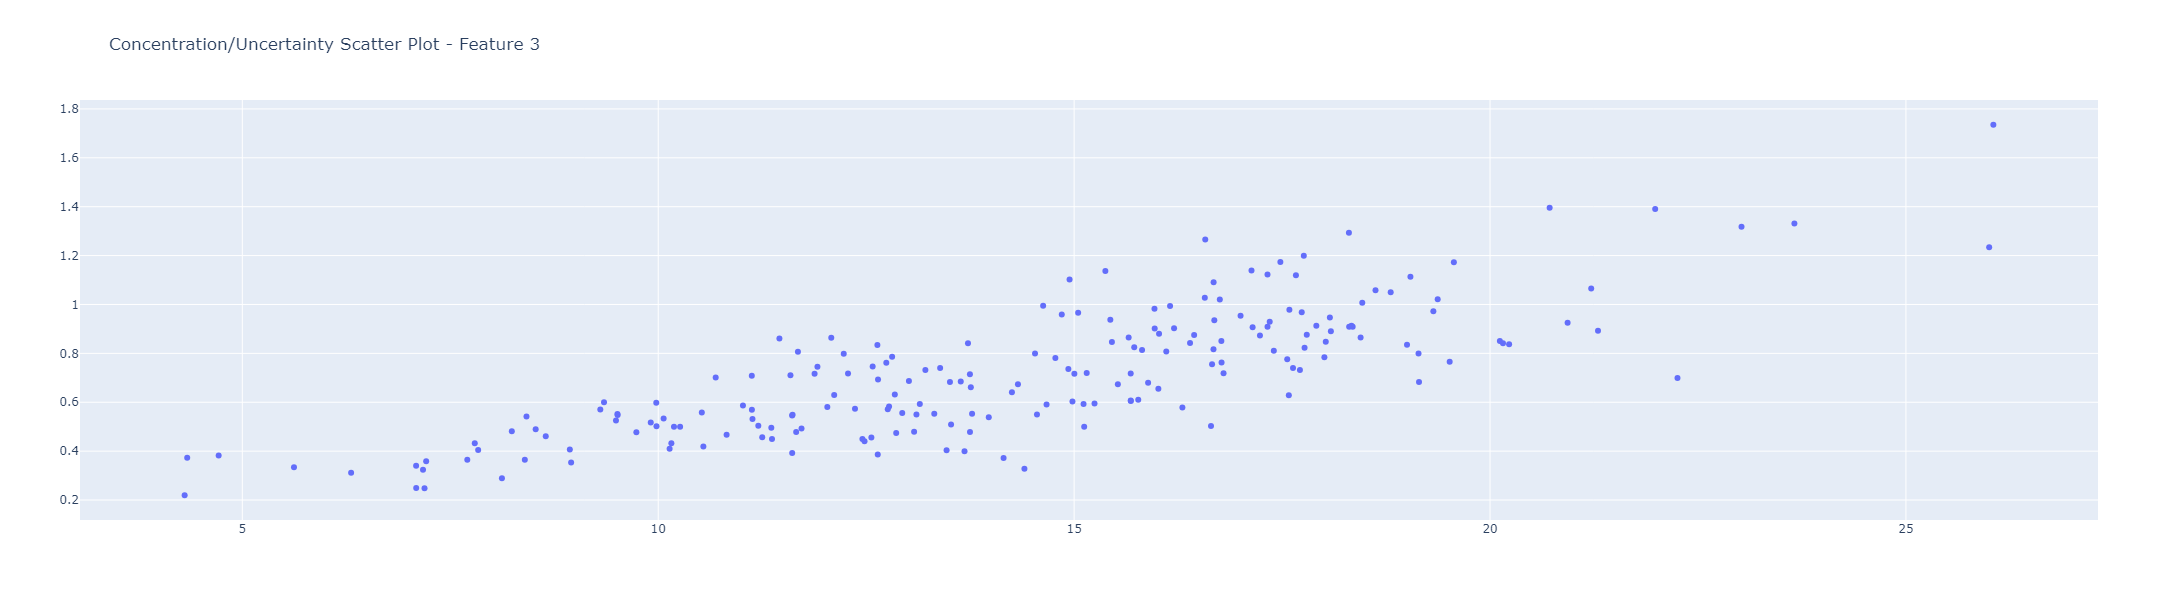

In [9]:
# Concentration / Uncertainty Scatter plot for specific feature, feature/column specified by index
data_handler.plot_data_uncertainty(feature_idx=2)

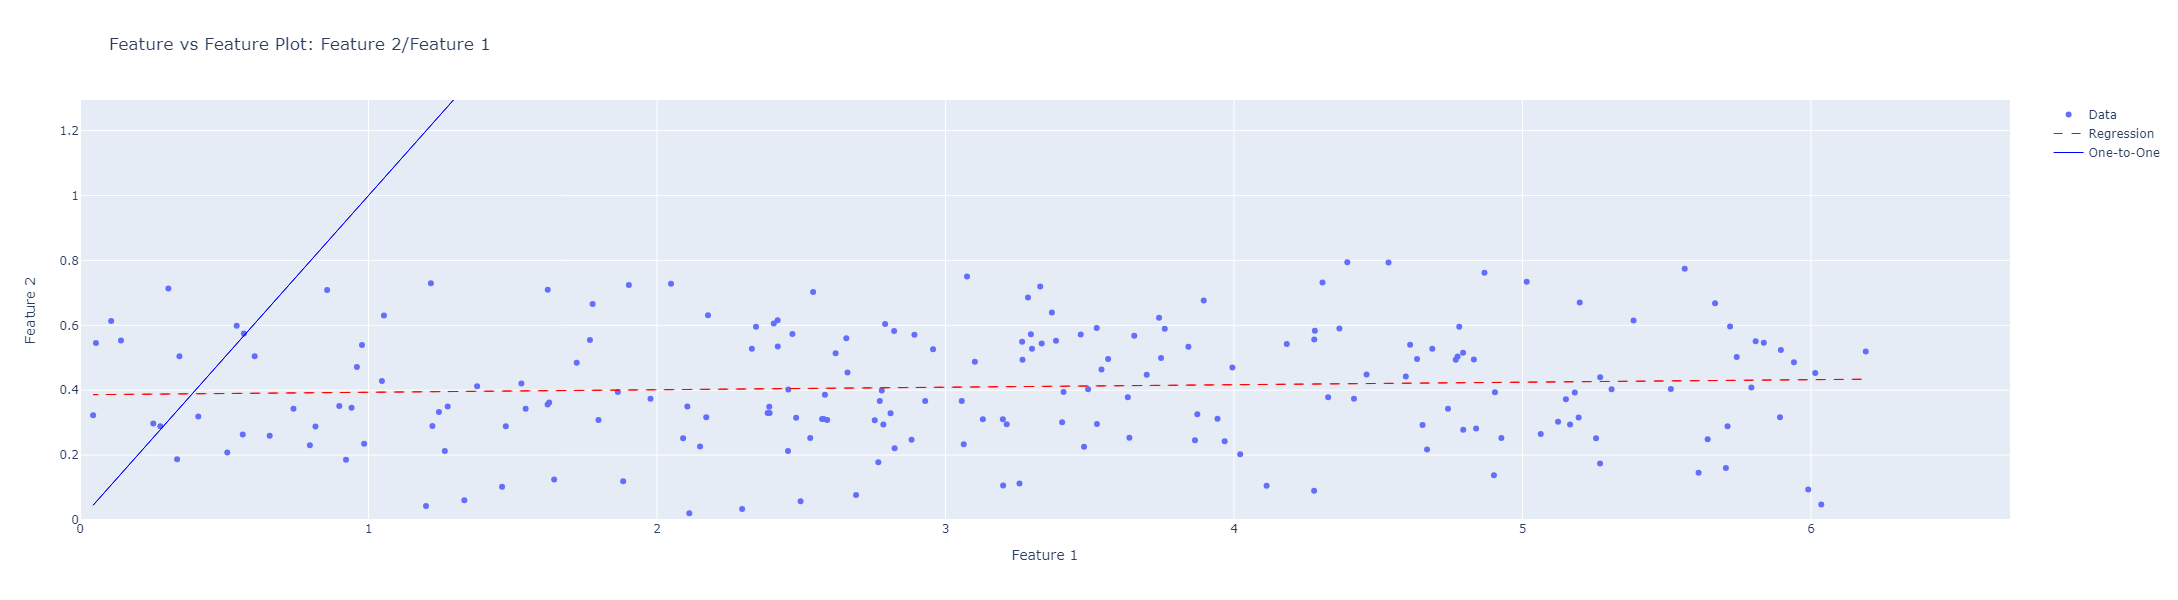

In [10]:
# Species Concentration plot comparing features, features/columns specified by index
data_handler.plot_feature_data(x_idx=0, y_idx=1)

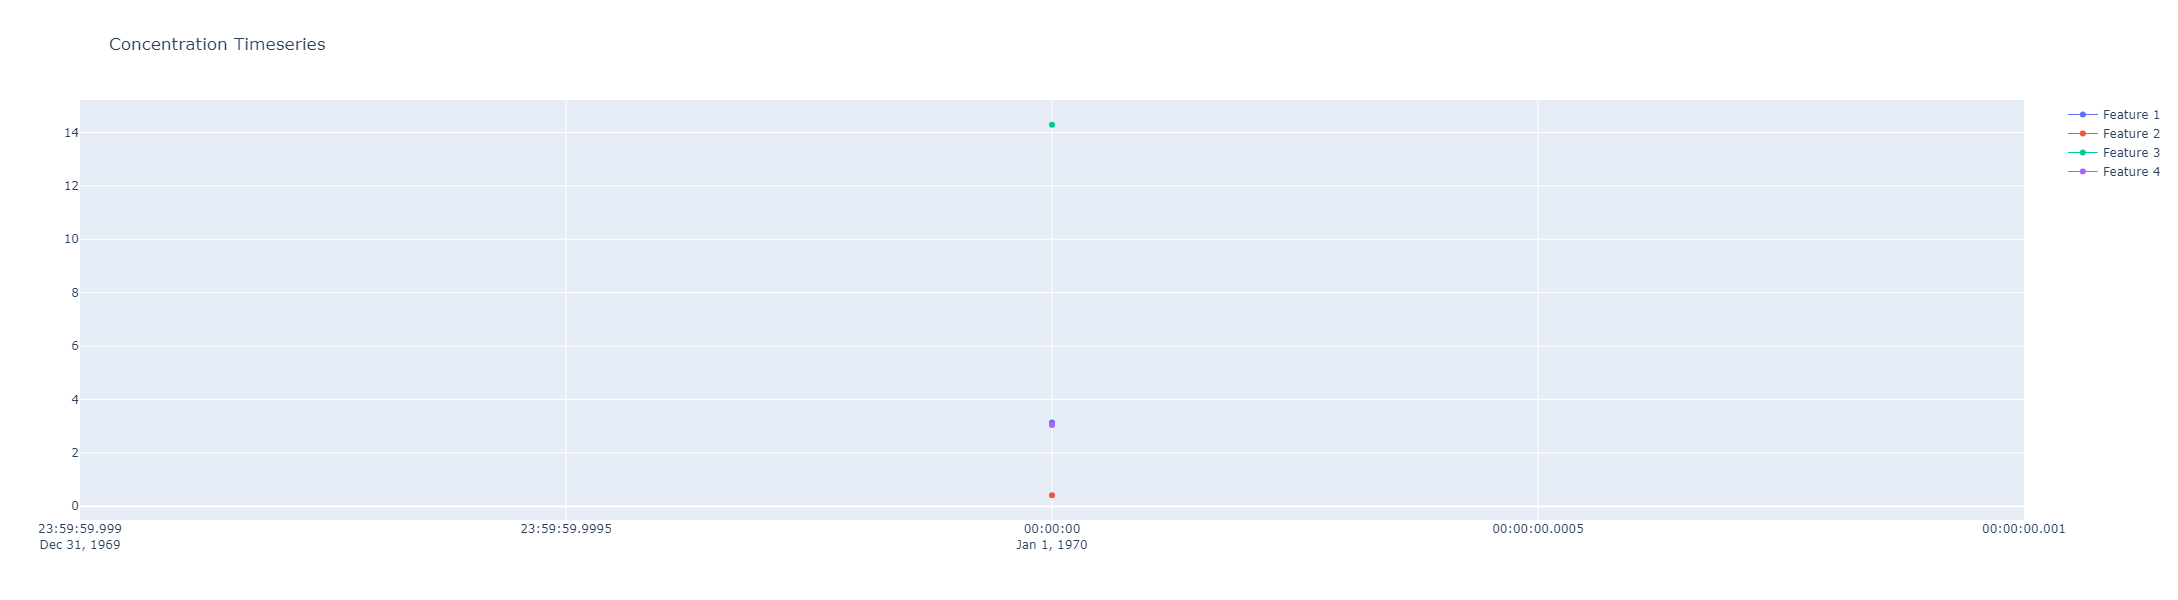

In [11]:
# Species Timeseries, a single or list of features/columns specified by index
data_handler.plot_feature_timeseries(feature_selection=[0, 1, 2, 3])

In [12]:
%%time
# Training multiple models, optional parameters are commented out.
sa_models = BatchSA(V=V, U=U, factors=factors, models=models, method=method, seed=seed, max_iter=max_iterations,
                    init_method=init_method, init_norm=init_norm,
                    converge_delta=converge_delta, converge_n=converge_n, 
                    parallel=parallel, optimized=optimized,
                    verbose=verbose
                   )
_ = sa_models.train()

17-Apr-24 12:37:37 - Model: 1, Q(true): 6073.8427, Q(robust): 6073.8427, Seed: 8925, Converged: True, Steps: 2409/20000
17-Apr-24 12:37:37 - Model: 2, Q(true): 6073.3734, Q(robust): 6073.3734, Seed: 77395, Converged: True, Steps: 2447/20000
17-Apr-24 12:37:37 - Model: 3, Q(true): 8064.8662, Q(robust): 6878.4354, Seed: 65457, Converged: True, Steps: 1423/20000
17-Apr-24 12:37:37 - Model: 4, Q(true): 6206.9867, Q(robust): 6184.4122, Seed: 43887, Converged: True, Steps: 2761/20000
17-Apr-24 12:37:37 - Model: 5, Q(true): 6074.2312, Q(robust): 6074.2312, Seed: 43301, Converged: True, Steps: 3647/20000
17-Apr-24 12:37:37 - Model: 6, Q(true): 6083.4651, Q(robust): 6083.4651, Seed: 85859, Converged: True, Steps: 2039/20000
17-Apr-24 12:37:37 - Model: 7, Q(true): 6075.3405, Q(robust): 6075.3405, Seed: 8594, Converged: True, Steps: 1514/20000
17-Apr-24 12:37:37 - Model: 8, Q(true): 6103.8697, Q(robust): 6103.8697, Seed: 69736, Converged: True, Steps: 2862/20000
17-Apr-24 12:37:37 - Model: 9, Q(t

CPU times: total: 93.8 ms
Wall time: 5.7 s


#### Train Model

In [13]:
# Selet the best performing model to review
best_model = sa_models.best_model
sa_model = sa_models.results[best_model]
best_model

9

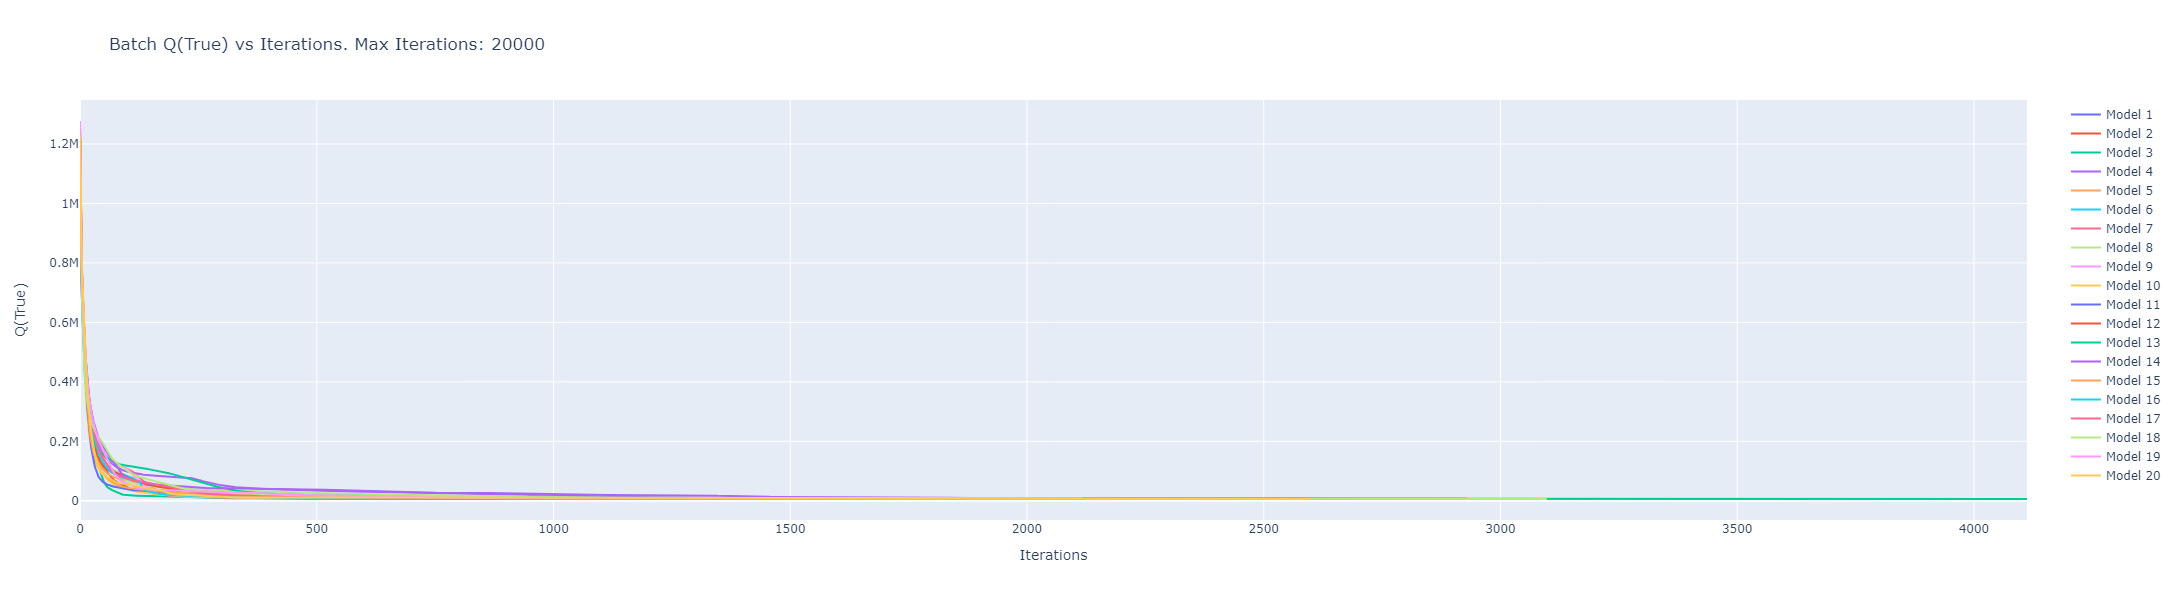

In [14]:
# Perform batch model analysis
batch_analysis = BatchAnalysis(batch_sa=sa_models)
# Plot the loss of the models over iterations
batch_analysis.plot_loss()

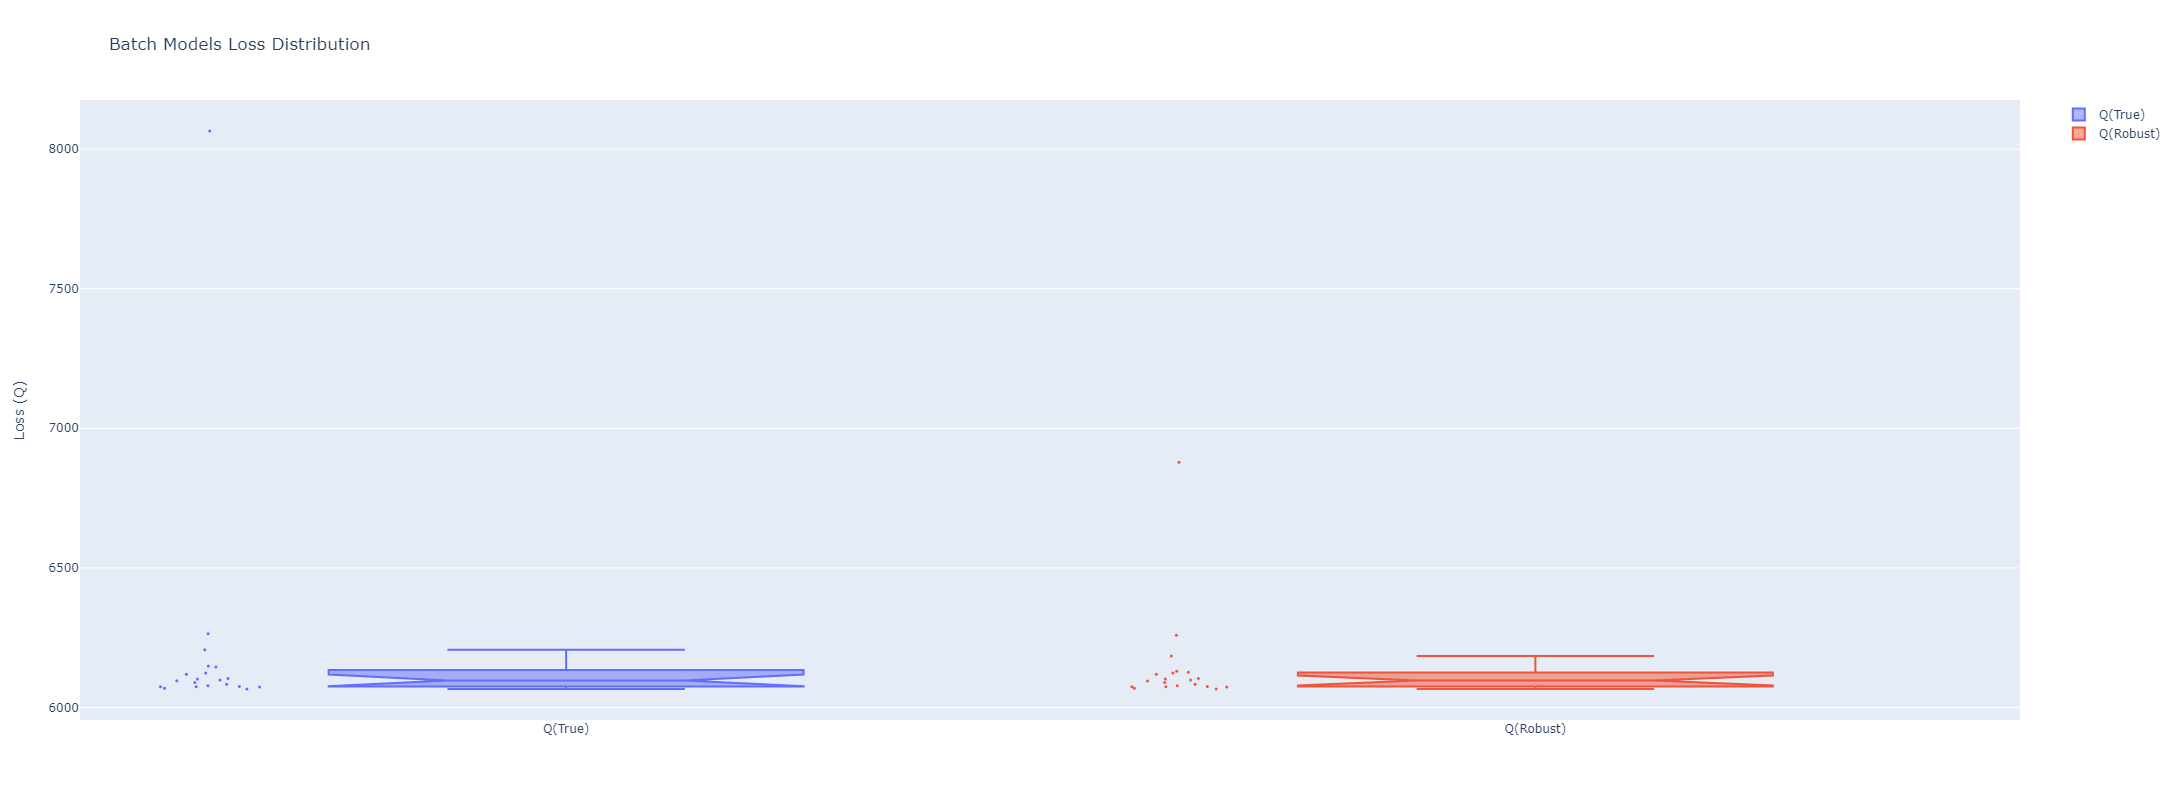

In [15]:
# Plot the loss distribution for the batch models
batch_analysis.plot_loss_distribution()

In [16]:
# Initialize the Model Analysis module
model_analysis = ModelAnalysis(datahandler=data_handler, model=sa_model, selected_model=best_model)

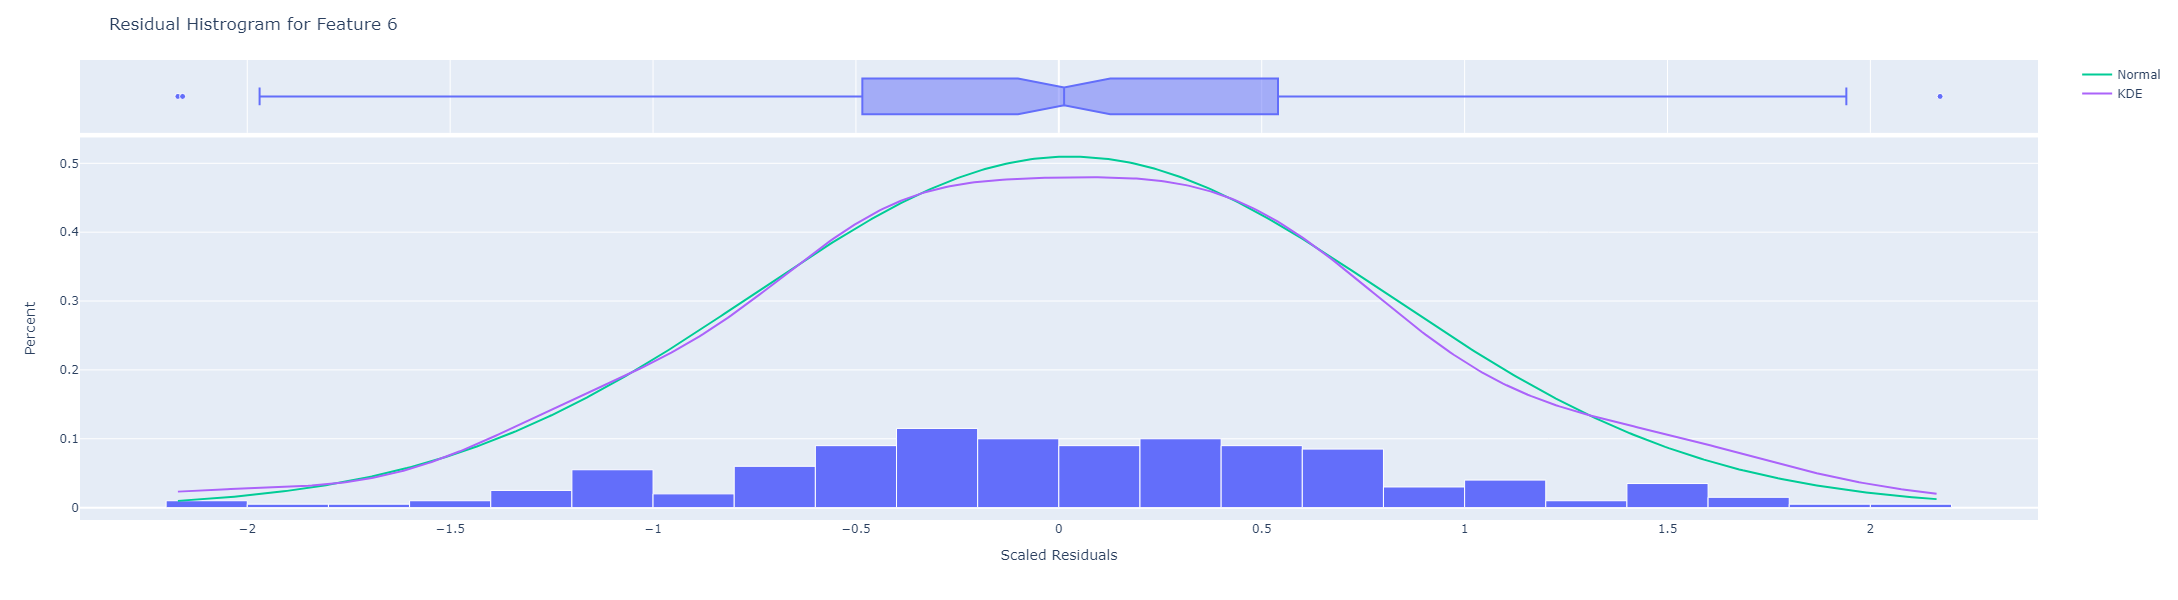

In [17]:
# Residual Analysis shows the scaled residual histogram, along with metrics and distribution curves. The abs_threshold parameter specifies the condition for the returned values of the function call as those residuals which exceed the absolute value of that threshold.
abs_threshold = 3.0
threshold_residuals = model_analysis.plot_residual_histogram(feature_idx=5, abs_threshold=abs_threshold)

In [18]:
print(f"List of Absolute Scaled Residual Greather than: {abs_threshold}. Count: {threshold_residuals.shape[0]}")
threshold_residuals

List of Absolute Scaled Residual Greather than: 3.0. Count: 0


Empty DataFrame
Columns: [Feature 6, datetime]
Index: []

In [19]:
# The model output statistics for the estimated V, including SE: Standard Error metrics, and 3 normal distribution tests of the residuals (KS Normal is used in PMF5)
model_analysis.calculate_statistics()
model_analysis.statistics

Features Category        r2  Intercept  Intercept SE     Slope  \
0    Feature 1   Strong  0.993062  -0.003870      0.021024  1.001179   
1    Feature 2   Strong  0.988586   0.007860      0.003335  0.974332   
2    Feature 3   Strong  0.978205   0.476381      0.151553  0.962700   
3    Feature 4   Strong  0.993937   0.013166      0.019642  0.993536   
4    Feature 5   Strong  0.979458   0.262198      0.151095  0.975394   
5    Feature 6   Strong  0.993302   0.006949      0.017194  0.996503   
6    Feature 7   Strong  0.979421   0.349246      0.091847  0.954620   
7    Feature 8   Strong  0.984331   0.043654      0.038613  0.983758   
8    Feature 9   Strong  0.986098   0.146415      0.100355  0.983268   
9   Feature 10   Strong  0.983964   0.319510      0.130059  0.973926   
10  Feature 11   Strong  0.975645   0.290789      0.164901  0.978493   
11  Feature 12   Strong  0.968728   0.280711      0.128075  0.969171   
12  Feature 13   Strong  0.989916   0.097670      0.061513  0.983534   
13  Feature 14   Strong  0.982363   0.326538      0.134766  0.970518   
14  Feature 15   Strong  0.977478   0.172386      0.122541  0.981369   
15  Feature 16   Strong  0.975808   0.262451      0.134941  0.972863   
16  Feature 17   Strong  0.984250   0.063259      0.089470  0.989849   
17  Feature 18   Strong  0.974614   0.460134      0.184027  0.966649   
18  Feature 19   Strong  0.994285   0.025981      0.026357  0.990416   
19  Feature 20   Strong  0.971165   0.203275      0.204382  0.982488   
20  Feature 21   Strong  0.992235   0.048760      0.034457  0.985393   
21  Feature 22   Strong  0.977730   0.418928      0.204783  0.974488   
22  Feature 23   Strong  0.981904   0.203745      0.128308  0.978512   
23  Feature 24   Strong  0.978694   0.301323      0.119335  0.969950   
24  Feature 25   Strong  0.981858   0.505686      0.169744  0.964353   
25  Feature 26   Strong  0.988452   0.018073      0.040009  0.995912   
26  Feature 27   Strong  0.993914   0.043450      0.034033  0.987244   
27  Feature 28   Strong  0.991944   0.017221      0.038430  0.992539   
28  Feature 29   Strong  0.987542   0.016255      0.008423  0.979177   
29  Feature 30   Strong  0.991835   0.004322      0.006497  0.992140   
30  Feature 31   Strong  0.984467   0.272328      0.091540  0.970167   
31  Feature 32   Strong  0.979182   0.014460      0.199212  1.000051   
32  Feature 33   Strong  0.973835   0.123287      0.194663  0.991998   
33  Feature 34   Strong  0.981199   0.034300      0.064976  0.985659   
34  Feature 35   Strong  0.995103   0.002321      0.002403  0.989833   
35  Feature 36   Strong  0.989750   0.064567      0.034690  0.983155   
36  Feature 37   Strong  0.990248   0.066214      0.060296  0.990750   
37  Feature 38   Strong  0.994214   0.041087      0.019248  0.980794   
38  Feature 39   Strong  0.991447   0.037107      0.032516  0.990437   
39  Feature 40   Strong  0.988485   0.187888      0.063070  0.972626   

    Slope SE        SE  SE Regression Anderson Normal Residual  \
0   0.005947  0.009621       0.136045                       No   
1   0.007440  0.001375       0.018890                     15.0   
2   0.010212  0.042048       0.575574                      2.5   
3   0.005515  0.010190       0.143607                      5.0   
4   0.010039  0.047239       0.658149                     15.0   
5   0.005816  0.008829       0.124743                     15.0   
6   0.009834  0.030470       0.409458                     15.0   
7   0.008821  0.013724       0.192443                     15.0   
8   0.008297  0.035498       0.496937                     15.0   
9   0.008836  0.040127       0.555405                     15.0   
10  0.010987  0.049986       0.700172                     15.0   
11  0.012375  0.035219       0.490447                     15.0   
12  0.007055  0.023415       0.326669                      2.5   
13  0.009241  0.046500       0.641332                       No   
14  0.010586  0.034966       0.490670                     15.0 

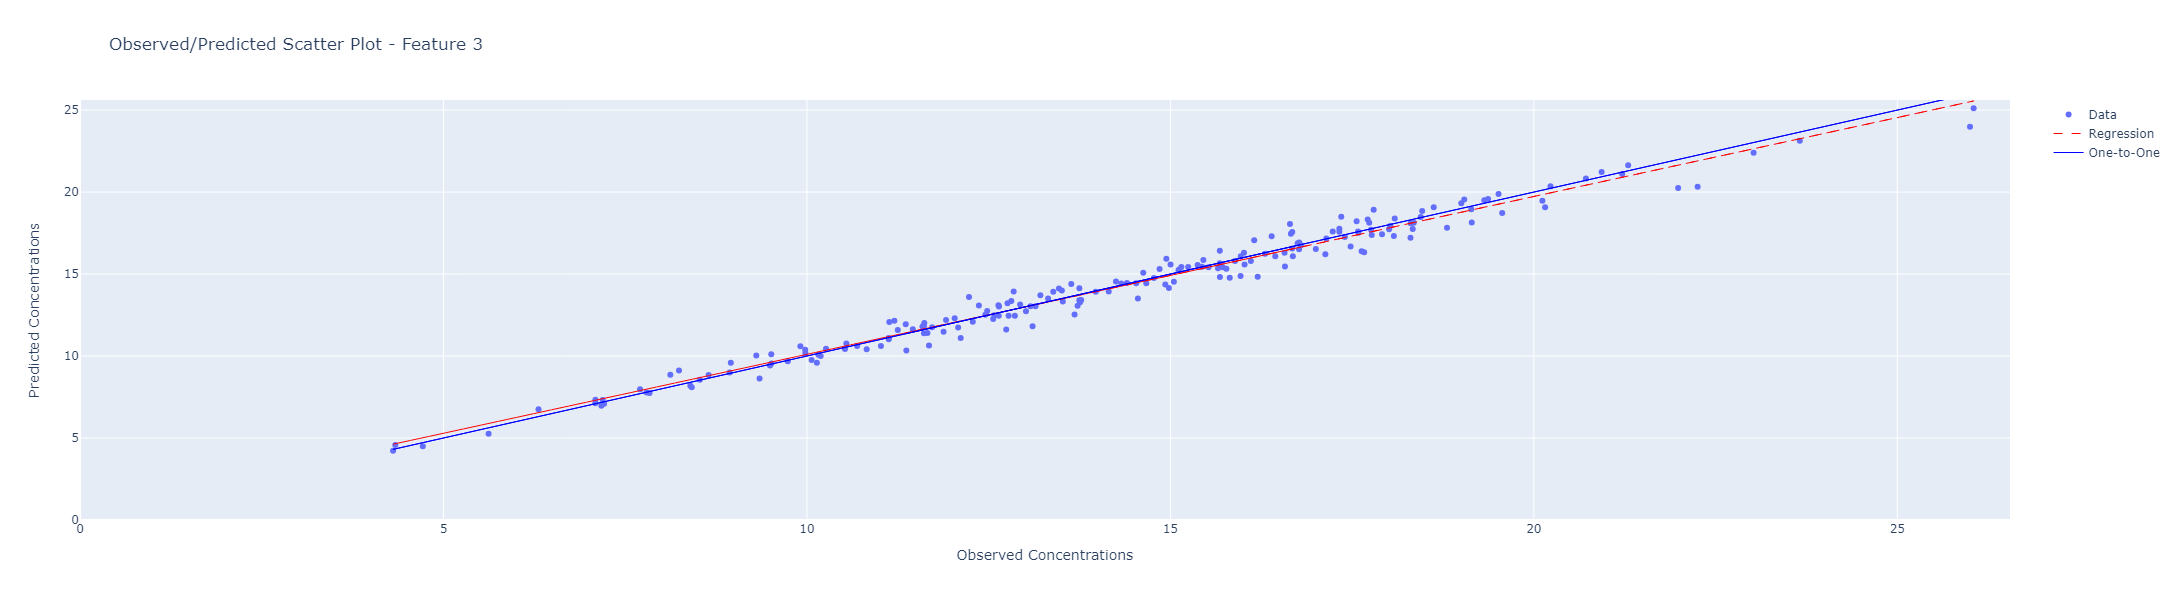

In [20]:
# Model feature observed vs predicted plot with regression and one-to-one lines. Feature/Column specified by index.
model_analysis.plot_estimated_observed(feature_idx=2)

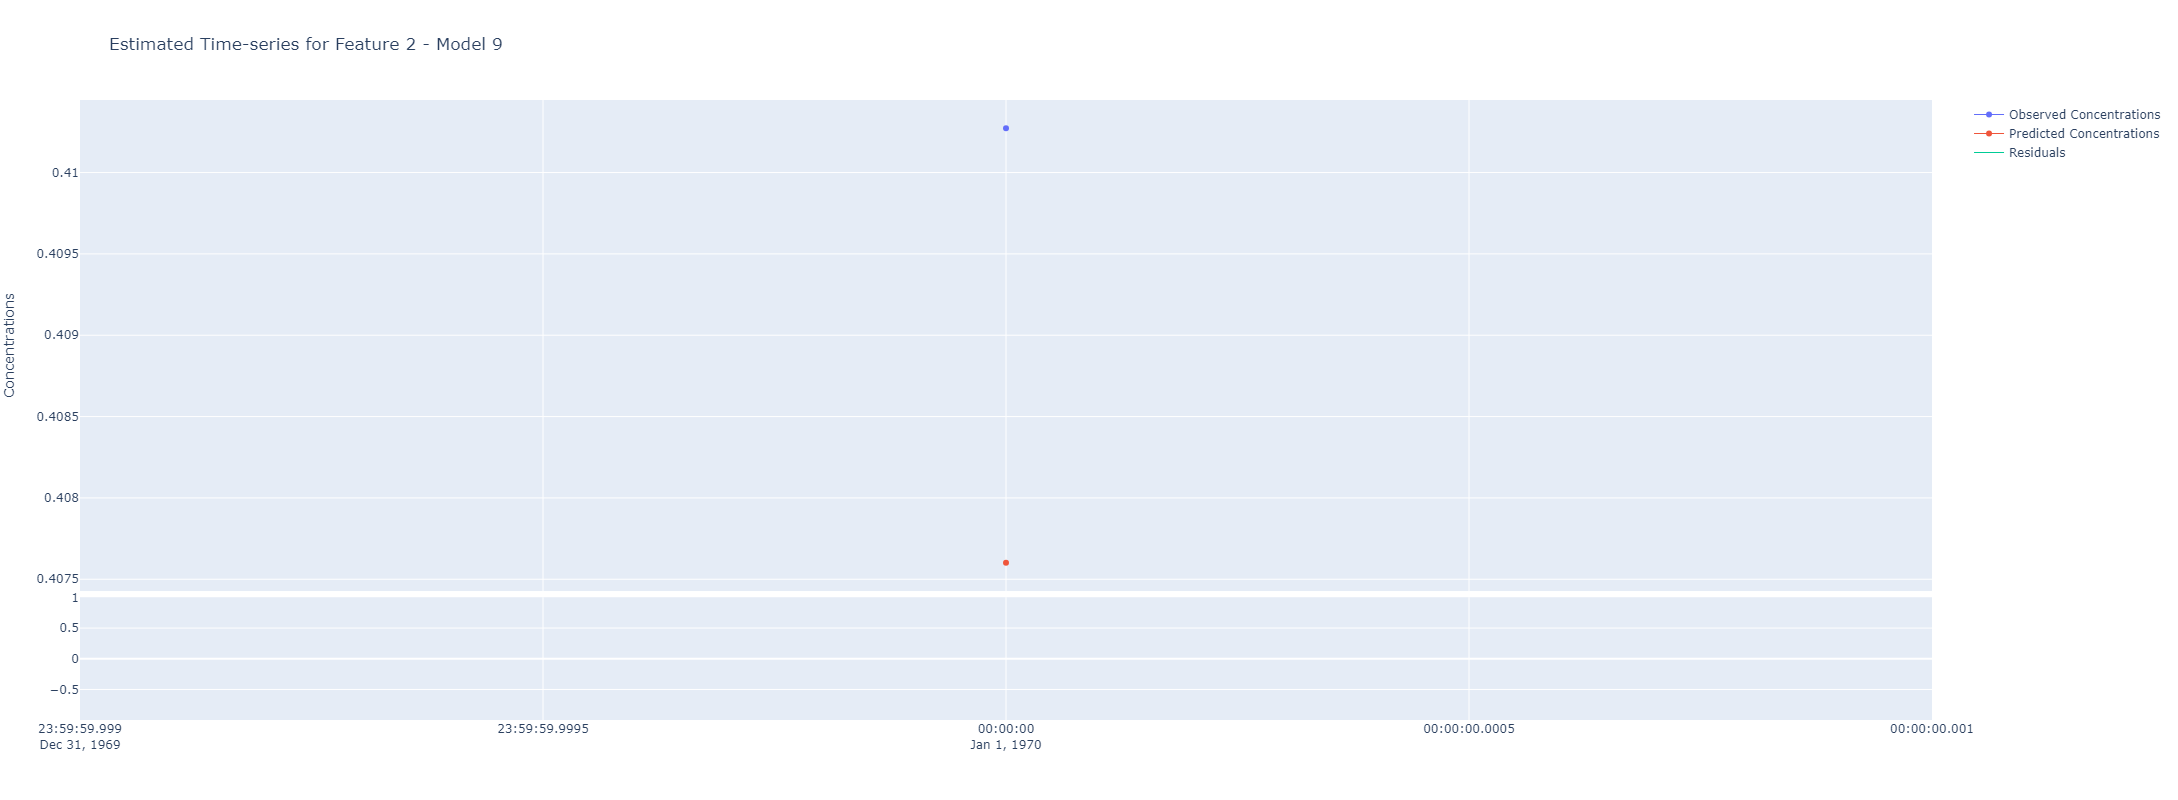

In [21]:
# Model feature timeseries analysis plot showing the observed vs predicted values of the feature, along with the residuals shown below. Feature/column specified by index.
model_analysis.plot_estimated_timeseries(feature_idx=1)

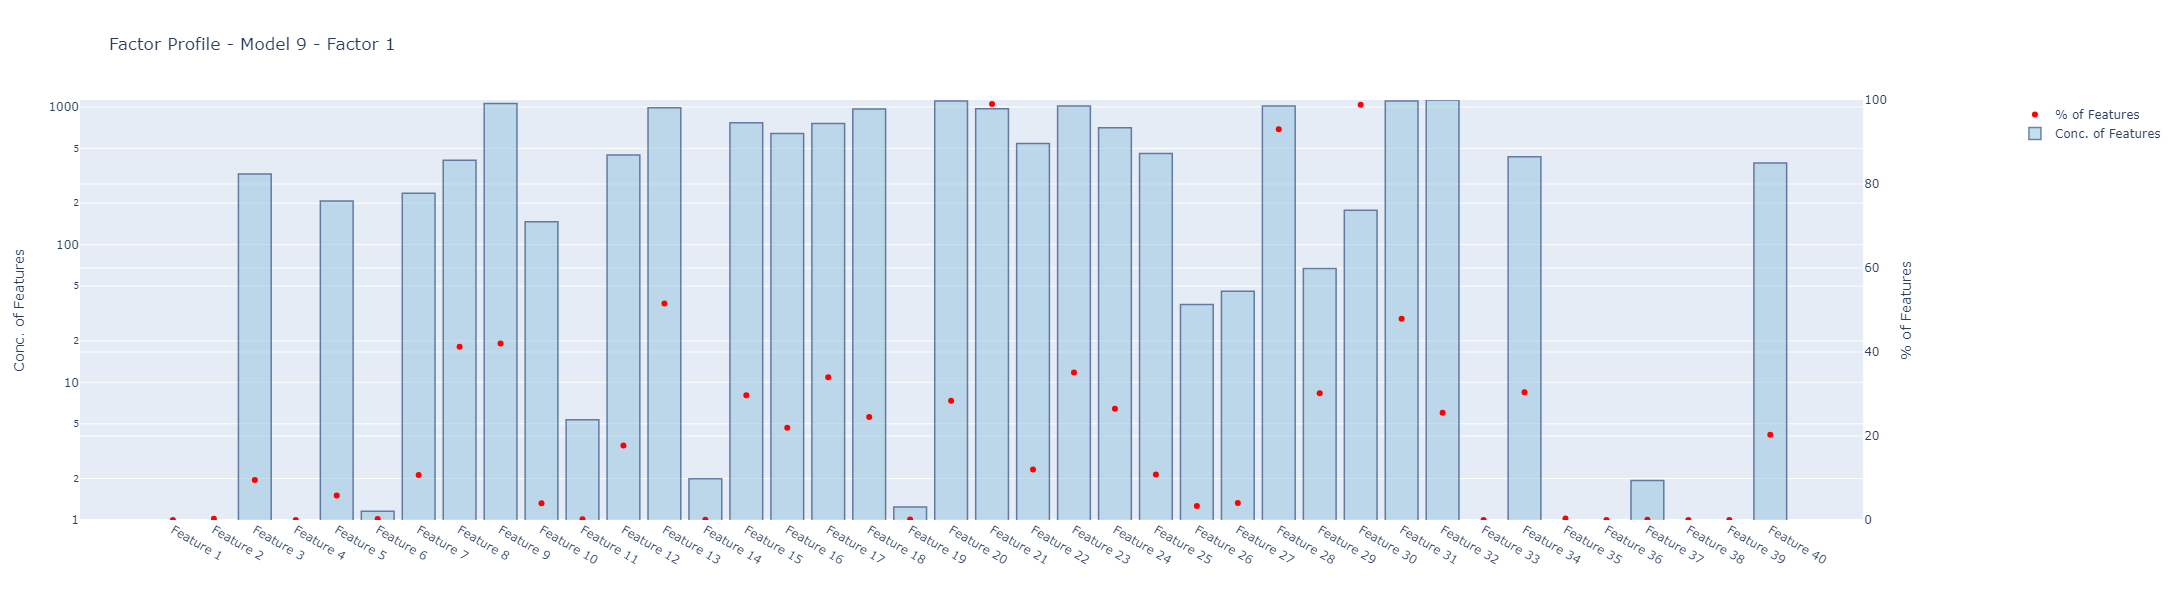

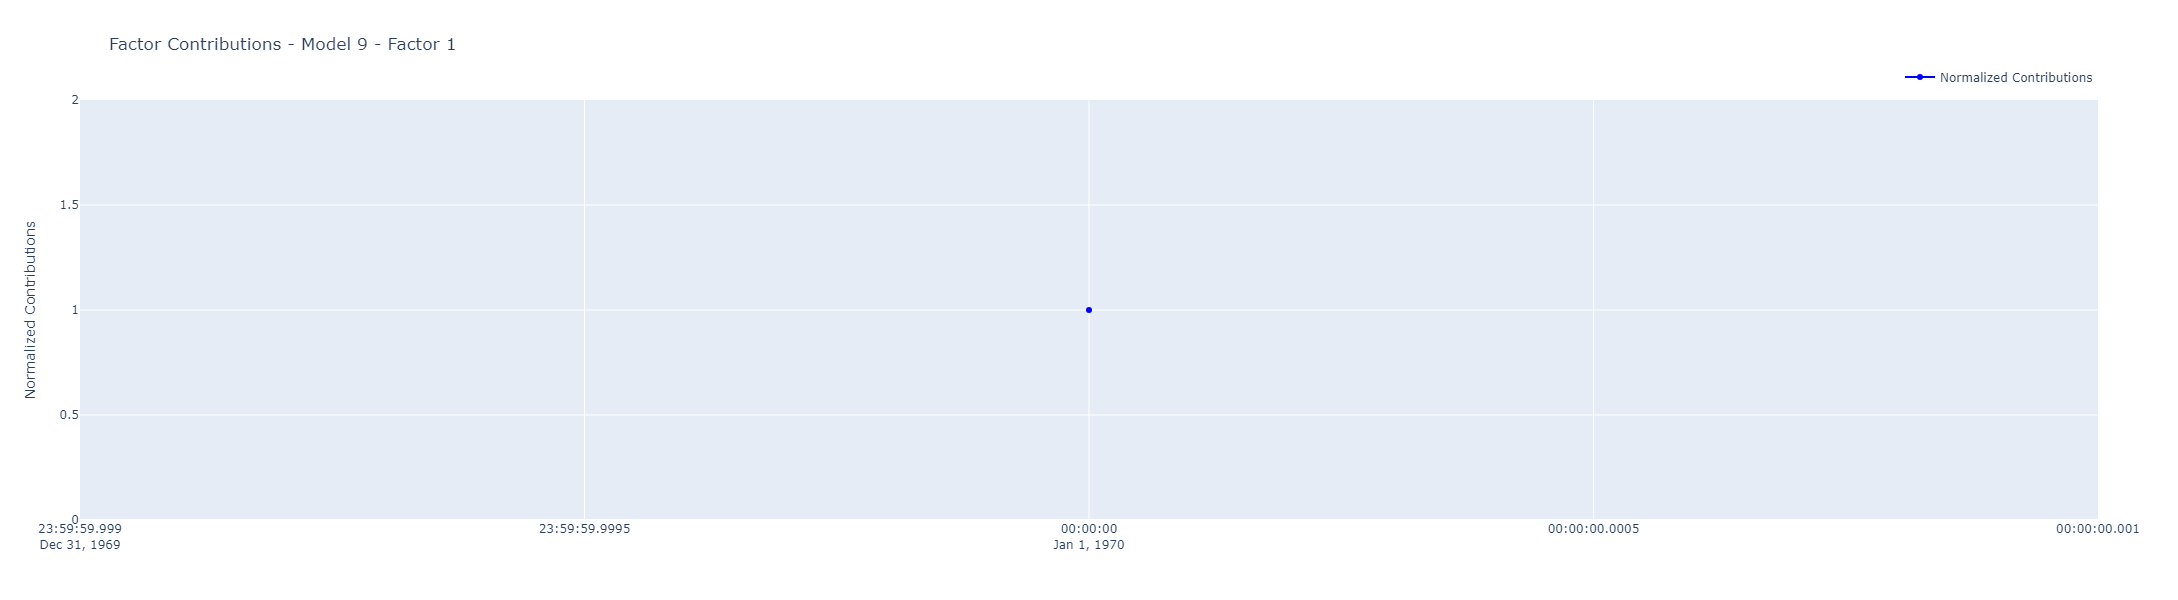

In [22]:
# Factor profile plot showing the factor sum of concentrations by feature (blue bars), the percentage of the feature as the red dot, and in the bottom plot the normalized contributions by date (values are resampled at a daily timestep for timeseries consistency).
# Factor specified by index.
model_analysis.plot_factor_profile(factor_idx=1)

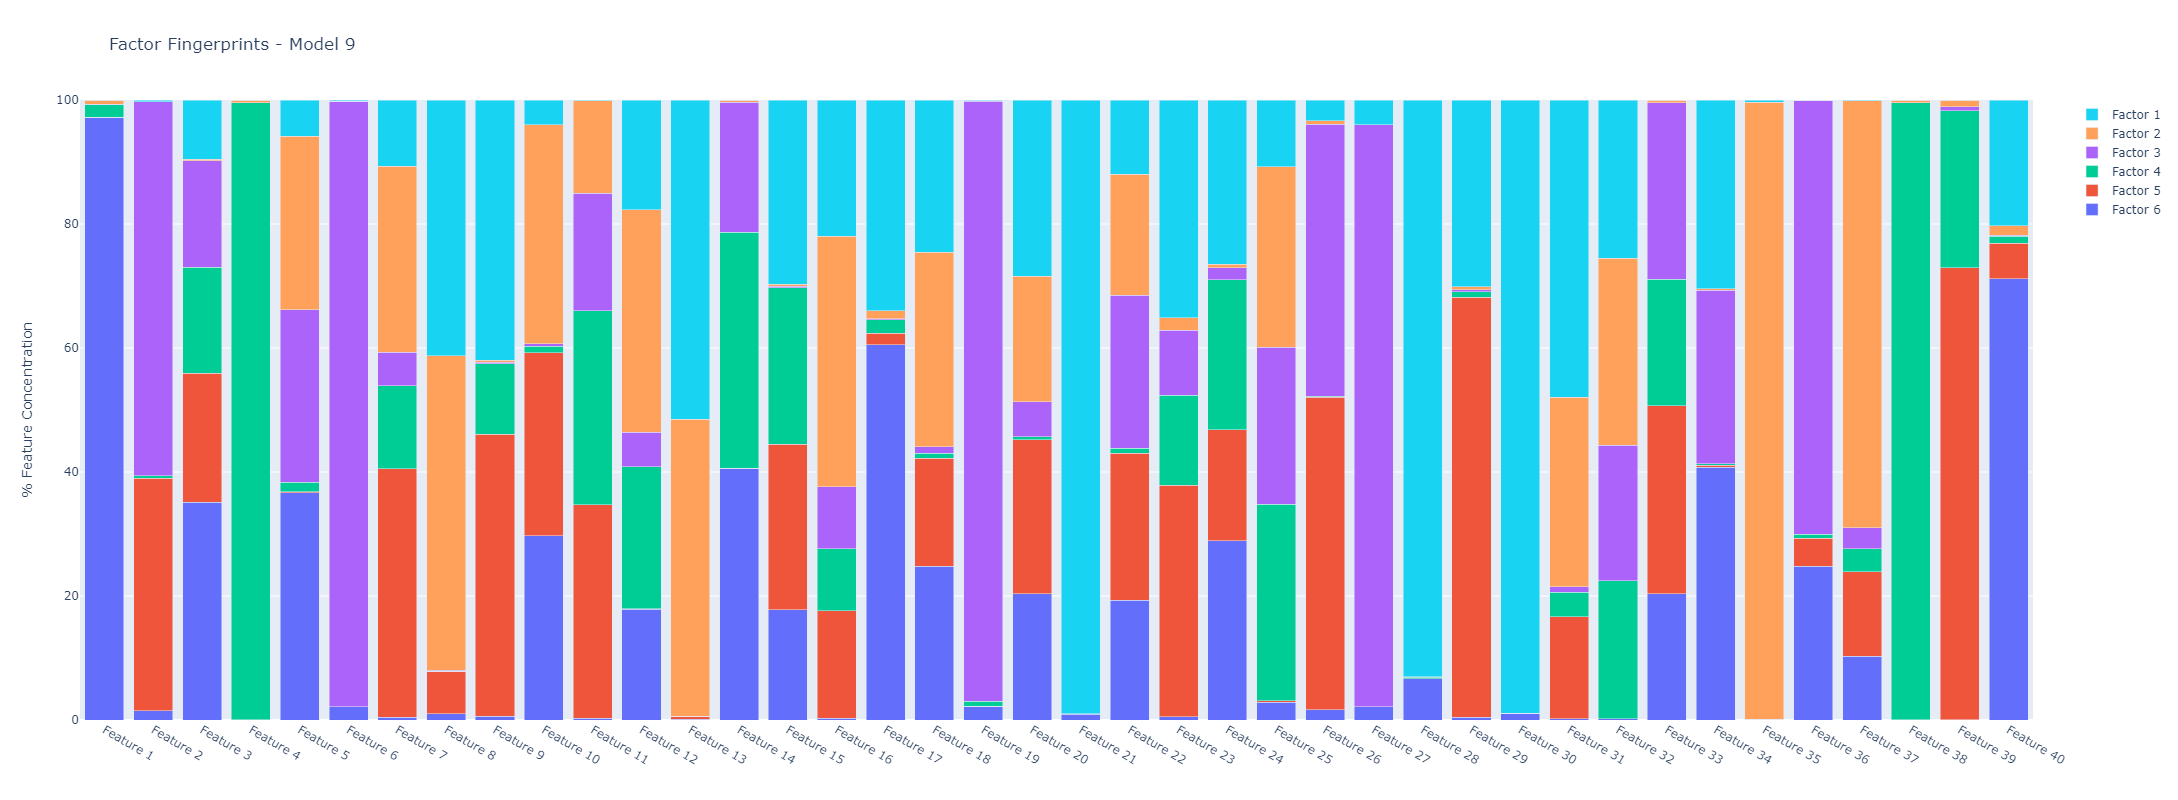

In [23]:
# Model factor fingerprint specifies the feature percentage of each factor.
model_analysis.plot_factor_fingerprints()

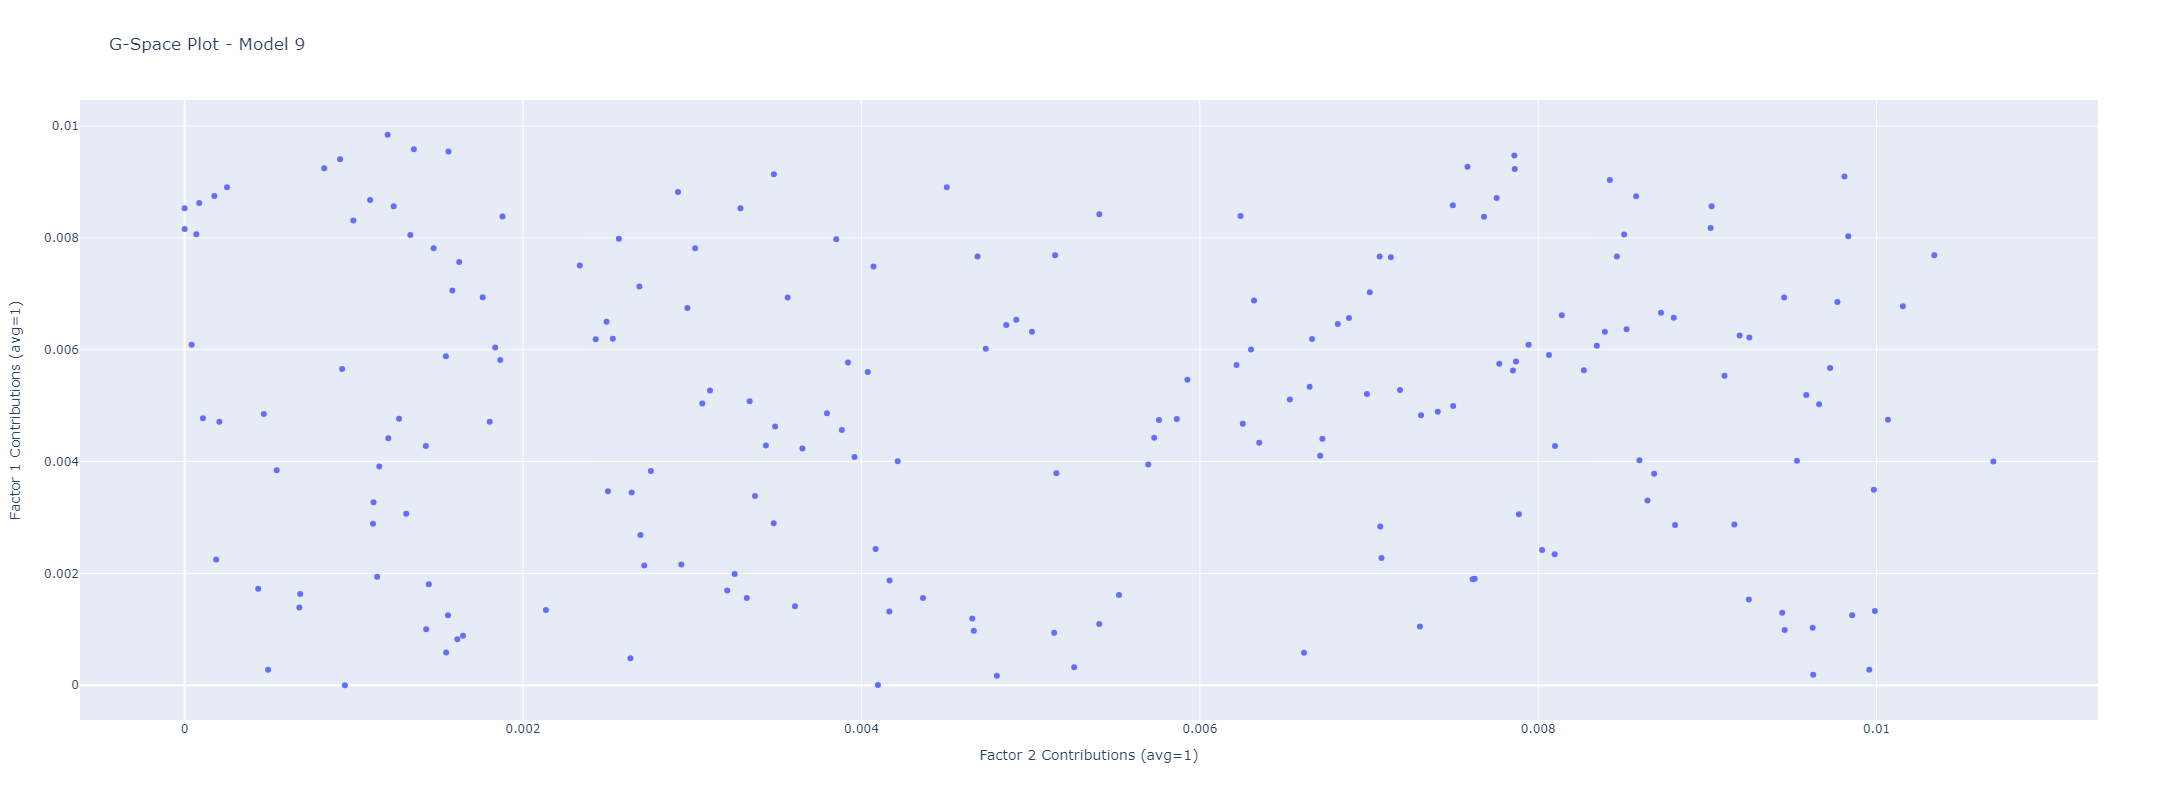

In [24]:
# Factor G-Space plot shows the normalized contributions of one factor vs another factor. Factor specified by index.
model_analysis.plot_g_space(factor_1=2, factor_2=1)

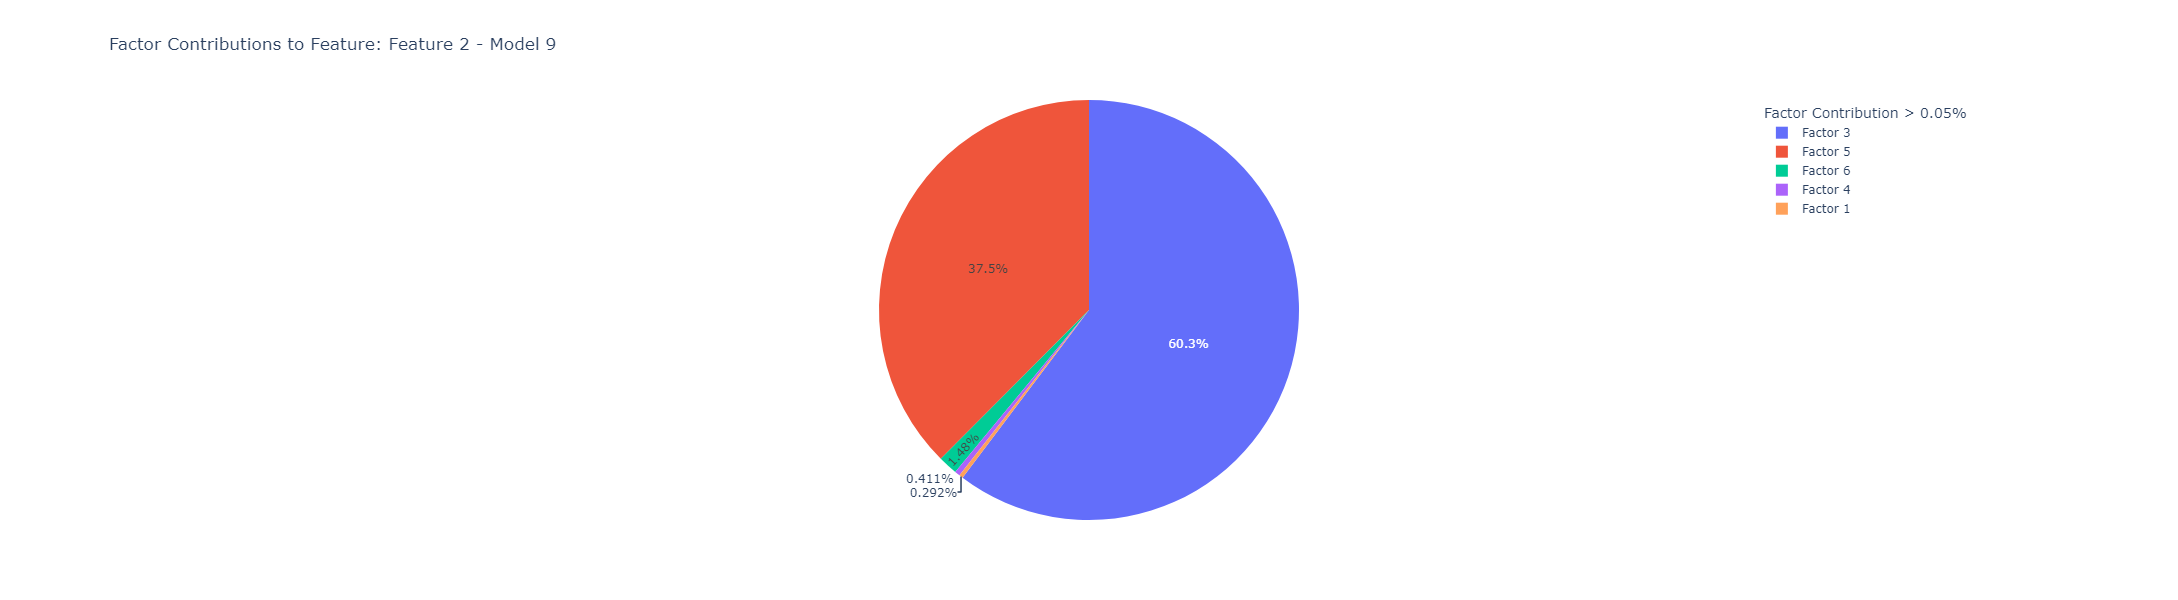

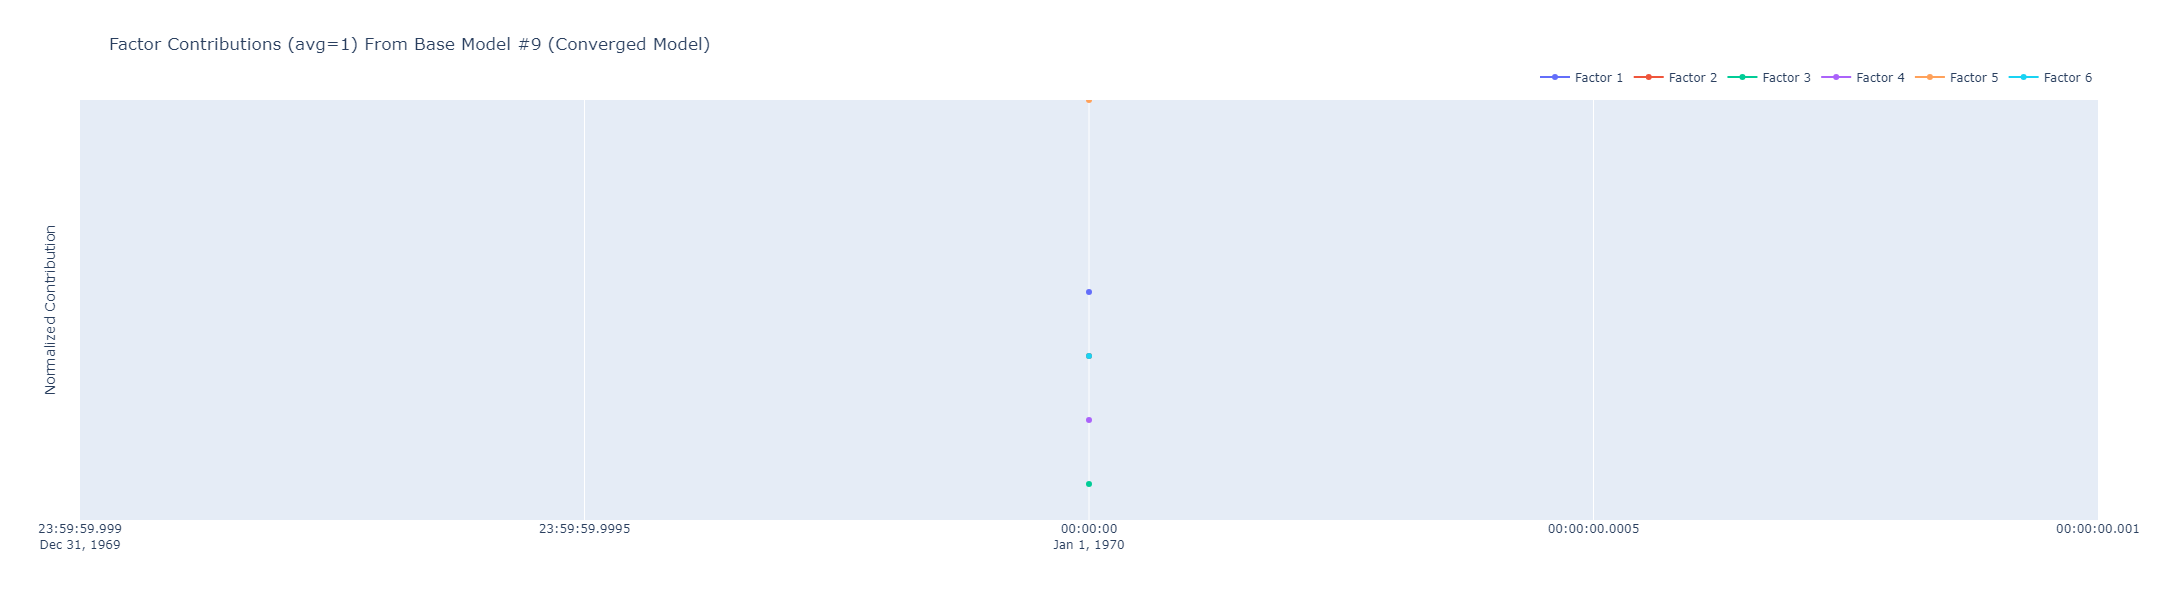

In [25]:
# Factor contribution pie chart shows the percentage of factor contributions for the specified feature, and the corresponding normalized contribution of each factor for that feature (bottom plot). Feature specified by index.
model_analysis.plot_factor_contributions(feature_idx=1)

### Compare to Synthetic Data

Compare the set of batch models to the original synthetic factor data.


In [26]:
from eval.factor_comparison import FactorCompare

In [27]:
factor_comp = FactorCompare(input_df=data_handler.input_data, uncertainty_df=data_handler.uncertainty_data, base_profile_df=syn_profile_df, base_contribution_df=syn_contribution_df, factors_columns=syn_factor_columns, features=syn_columns, batch_sa=sa_models)

In [28]:
factor_comp.compare()

Calculating correlation between factors from each epoch: 100%|█████████████████████████| 20/20 [00:00<00:00, 21.27it/s]


Number of permutations for 6 factors: 720


Calculating average correlation for all permutations for each epoch: 100%|█████████████| 20/20 [01:40<00:00,  5.02s/it]

R2 - Model: 2, Best permutations: ['Factor 4', 'Factor 2', 'Factor 3', 'Factor 5', 'Factor 1', 'Factor 6'], Average R2: 0.998363638922735, 
Profile R2 Avg: 0.9993928455054694, Contribution R2 Avg: 0.997259365445417, WH R2 Avg: 0.9984387058173189
Profile R2: [0.9990857060333408, 0.999358685149491, 0.9995867512672377, 0.999406629890505, 0.9992160539205562, 0.9997032467716852], 
Contribution R2: [0.9974153026054408, 0.9970119281609272, 0.9985265458704258, 0.9957587596966327, 0.9972973964532633, 0.9975462598858126], 
WH R2: [0.9981866453388801, 0.9983105867389263, 0.9990634929036256, 0.9979873838436369, 0.9982353125387277, 0.9988488135401159]

Base Q(true): 75.2525344365774, SA Model 2 Q(true): 6073.373407140321


In [29]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

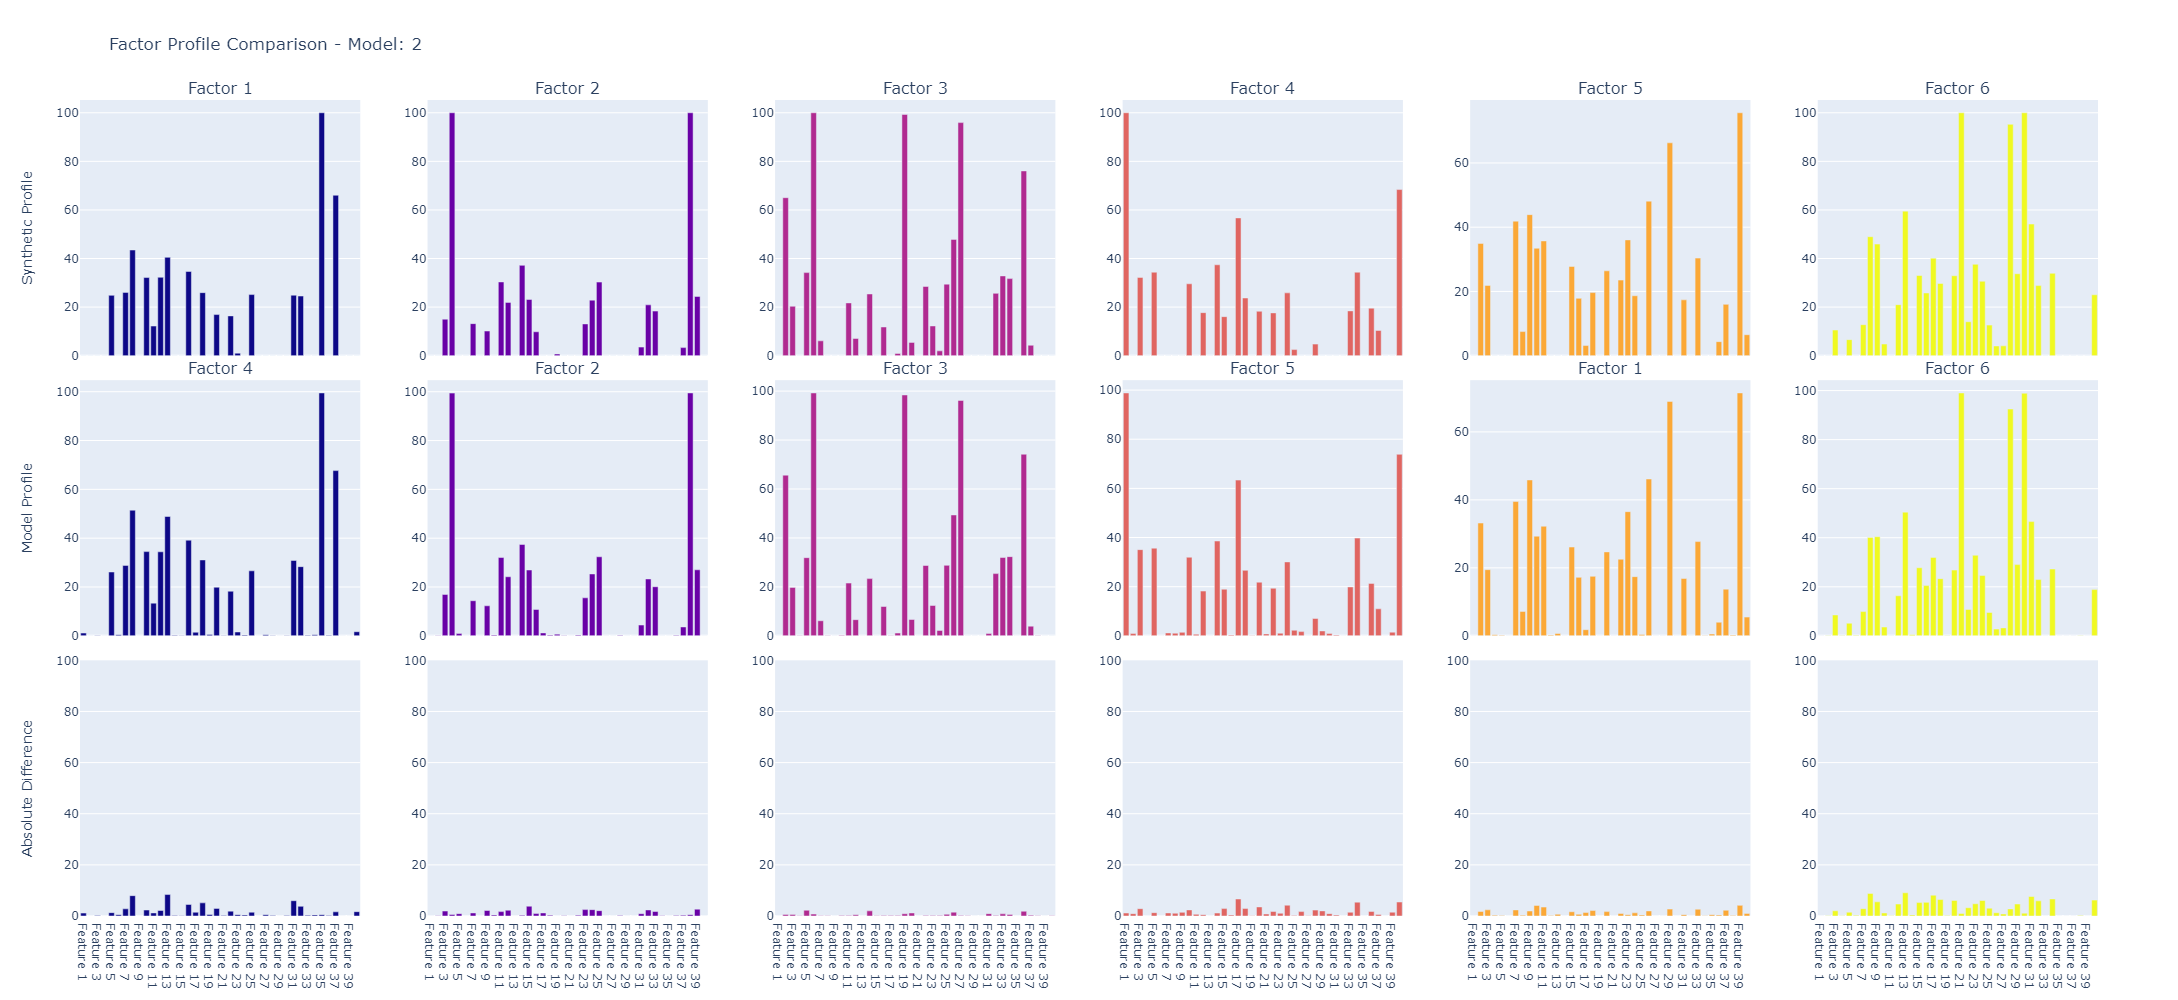

In [30]:
color_map = px.colors.sample_colorscale("plasma", [n/(factors -1) for n in range(factors)])

c_model = sa_models.results[factor_comp.best_model]
syn_H = syn_factor_profiles
norm_syn_H = 100 * (syn_H / syn_H.sum(axis=0))

_H = sa_models.results[factor_comp.best_model].H
norm_H = 100 * (_H / _H.sum(axis=0))
subplot_titles = [f"Factor {i}" for i in range(1, factors+1)] + factor_comp.factor_map

h_fig = make_subplots(rows=3, cols=factors, shared_xaxes=True, vertical_spacing=0.03, subplot_titles=subplot_titles)
for i in range(1, factors+1):
    h_fig.add_trace(go.Bar(name=f"Factor {i}", x=data_handler.features, y=norm_syn_H[i-1], marker_color=color_map[i-1]), row=1, col=i)
    map_i = int(factor_comp.factor_map[i-1].split(" ")[1]) - 1
    h_fig.add_trace(go.Bar(name=f"Factor {factor_comp.factor_map[i-1]}", x=data_handler.features, y=norm_H[map_i], marker_color=color_map[i-1]), row=2, col=i)
    h_fig.add_trace(go.Bar(name="", x=data_handler.features, y=np.abs(norm_syn_H[i-1]- norm_H[map_i]), marker_color=color_map[i-1]), row=3, col=i)
h_fig.update_yaxes(title_text="Synthetic Profile", row=1, col=1)
h_fig.update_yaxes(title_text="Model Profile", row=2, col=1)
h_fig.update_yaxes(title_text="Absolute Difference", row=3, col=1)
h_fig.update_yaxes(row=3, range=[0, 100])
h_fig.update_layout(title_text=f"Factor Profile Comparison - Model: {factor_comp.best_model+1}", width=1600, height=1000, hovermode='x unified', showlegend=False)
h_fig.show()

array([2.00000000e-10, 2.00000000e-10, 2.00000000e-10, 2.00000000e-10,
       1.29258153e+02, 2.00000000e-10, 8.45468069e+01, 6.40794407e+01,
       2.00000000e-10, 1.63961772e+02, 6.47873338e+01, 1.16950541e+02,
       1.17866233e+02, 2.00000000e-10, 2.00000000e-10, 1.51107908e+02,
       2.00000000e-10, 1.48691992e+02, 2.00000000e-10, 9.93180958e+01,
       2.00000000e-10, 1.12878536e+02, 4.79407111e+00, 2.00000000e-10,
       1.61793921e+02, 2.00000000e-10, 2.00000000e-10, 2.00000000e-10,
       2.00000000e-10, 2.00000000e-10, 8.90032110e+01, 1.66003836e+02,
       2.00000000e-10, 2.00000000e-10, 1.54872171e+01, 2.00000000e-10,
       1.95438546e+02, 2.00000000e-10, 2.00000000e-10, 2.00000000e-10])